### 1. Creating Enviorment and Installing Dependencies
```bash
conda create -n clock python=3.7.2
conda activate clock
conda deactivate

pip install matplotlib ipykernel tensorflow opencv-python scipy pydot graphviz
```

### 2. Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

#### 2.1 Print messages in RGB

In [2]:
def print_in_color(txt_msg, fore_tupple, back_tupple):
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = ('\33[38;2;' + str(rf) + ';' + str(gf) +
           ';' + str(bf) + ';48;2;' + str(rb) +
           ';' + str(gb) + ';' + str(bb) + 'm')
    print(msg.format(mat))

### 3. Visualizing and Preprocessing Data

#### 3.1. Visualizing Data

In [3]:
sdir = r'./data/'
sdir_gray = r'./data_gray/'
train_dir = os.path.join(sdir, 'train')

msg = '{0:8s}{1:4s}{2:^28s}{1:4s}{3:8s}{1:3s}{4:8s}{1:3s}{5:7s}{6}'
msg = msg.format('ClassID', ' ', 'Clock Time ', 'Train', 'Test', 'Valid', '\n')
print_in_color(msg, (0, 255, 255), (0, 0, 0))

species_list = sorted(os.listdir(train_dir))
for i, specie in enumerate(species_list):
    file_path = os.path.join(train_dir, specie)
    train_files_list = os.listdir(file_path)
    train_file_count = str(len(train_files_list))

    msg = '{0:^8s}{1:4s}{2:^28s}{1:4s}{3:^8s}{1:1s}{4:^8s}{1:3s}{5:^8s}'
    msg = msg.format(str(i), ' ', specie, train_file_count, '5', '5')

    toggle = i % 2
    back_color = (0, 0, 0) if toggle == 0 else (191, 239, 242)

    print_in_color(msg, (255, 255, 255), back_color)

ClassID             Clock Time              Train      Test       Valid  

   0                    1-00                   80       5          5    
   1                    1-05                   80       5          5    
   2                    1-10                   80       5          5    
   3                    1-15                   80       5          5    
   4                    1-20                   80       5          5    
   5                    1-25                   80       5          5    
   6                    1-30                   80       5          5    
   7                    1-35                   80       5          5    
   8                    1-40                   80       5          5    
   9                    1-45                   80       5          5    
   10                   1-50                   80       5          5    
   11                   1-55                   80       5          5    
   12                  10-00                   80

### 3.2 change color channel to grayscale
(better performance)

In [4]:
# import cv2

# # Define source and target directories
# src_dir = 'data/test'
# tgt_dir = 'data/test_gray'

# # Create target directory if it doesn't exist
# os.makedirs(tgt_dir, exist_ok=True)

# # Iterate over all files in source directory
# for dirpath, dirnames, filenames in os.walk(src_dir):
#     for filename in filenames:
#         # Construct full file path
#         src_file = os.path.join(dirpath, filename)

#         # Load image
#         img = cv2.imread(src_file)

#         # Convert image to grayscale
#         img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#         # Construct target file path
#         tgt_file = os.path.join(tgt_dir, os.path.relpath(src_file, src_dir))

#         # Create target directory if it doesn't exist
#         os.makedirs(os.path.dirname(tgt_file), exist_ok=True)

#         # Save grayscale image
#         cv2.imwrite(tgt_file, img_gray)

# # 6m 33.4s for train
# # 0m 47.0s for valid
# # 0m 46.4s for test

There are 144 labels(class ids) each representing the time at which time the \
clock images are pointing to.
Each class has 80 training images and 5 testing images.

In [5]:
from IPython.core.getipython import get_ipython

# choose between RGB or grayscale data:
user_input = input('RGB or grayscale data? (r/g): ')

if user_input == 'r':
    train_dir = os.path.join(sdir, 'train')
elif user_input == 'g':
    train_dir = os.path.join(sdir_gray, 'train_gray')
else:
    print('Invalid input')
    get_ipython().ask_exit()

# list of every dir in test directory
test_species_list = sorted(os.listdir(train_dir))
classes = len(os.listdir(train_dir))

rows = int(classes/5) if classes % 5 == 0 else int(classes/5) + 1

size = int(classes/5)*4
fig = plt.figure(figsize=(20, size))
img = ''

for row in range(rows):
    for column in range(5):
        i = row * 5 + column
        if i > classes-1:
            break

        specie = test_species_list[i]
        species_path = os.path.join(train_dir, specie)
        flist = os.listdir(species_path)
        # we get only the first image
        f_path = os.path.join(species_path, flist[12])
        img = mpimg.imread(f_path)

        # plt.subplot(rows, 5, i+1)
        # plt.axis('off')
        # plt.title(specie)
        # plt.imshow(img)

print(img.shape)

# plt.show()

(224, 224)


<Figure size 2000x11200 with 0 Axes>

#### 3.3 Importing Data

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object
datagen = ImageDataGenerator(rescale=1./255)

# Load images from the specified directory
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # adjust this to the size of your images
    batch_size=32, # number of images to load at a time
    class_mode='categorical',  # use 'categorical' for multi-class problems
    color_mode='grayscale' # or 'rgb' TODO: make an if
)

print(train_generator.next()[0].shape) # has a shape of (32, 224, 224, 1)

Found 11520 images belonging to 144 classes.
(32, 224, 224, 1)


### 4. Creating Model

#### 4.1 Building Generator

In [7]:
from keras.layers import Input, Dense, Reshape, LeakyReLU, UpSampling2D, Conv2D, Concatenate, Embedding, Flatten
from keras.models import Model


def build_cgan_generator(noise_dim=128, num_classes=144):
    # Noise input
    noise = Input(shape=(noise_dim,))
    noise_layer = Dense(7 * 7 * 128)(noise)
    noise_layer = LeakyReLU(0.2)(noise_layer)

    # Label input
    label = Input(shape=(1,))
    label_embedding = Embedding(num_classes, noise_dim)(label)
    label_embedding = Flatten()(label_embedding)  # Flatten the embedding output
    label_layer = Dense(7 * 7 * 128)(label_embedding)
    label_layer = LeakyReLU(0.2)(label_layer)
    
    print(noise_layer.shape, label_layer.shape)
    print('Dima')
    # Concatenate noise and label layers
    concat = Concatenate()([noise_layer, label_layer]) # here is the problem
    concat = Reshape((7, 7, 256))(concat)

    # Upsampling and Conv2D layers
    x = UpSampling2D()(concat)
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    # Add more upsampling and Conv2D layers to increase the output size to 224x224
    x = UpSampling2D()(x)
    x = Conv2D(128, 5, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    x = UpSampling2D()(x)
    x = Conv2D(64, 5, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, 5, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    x = UpSampling2D()(x)
    x = Conv2D(16, 5, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    # Final Conv2D layer
    x = Conv2D(1, 5, padding='same', activation='sigmoid')(x)  # -> 224x224x1

    # Create model
    model = Model([noise, label], x, name='cgan_generator')

    return model


# Create conditional GAN generator
cgan_generator = build_cgan_generator()
cgan_generator.summary()

(None, 6272) (None, 6272)
Dima
Model: "cgan_generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 128)       18432       ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 128)          0           ['embedding[0][0]']              
                                                      

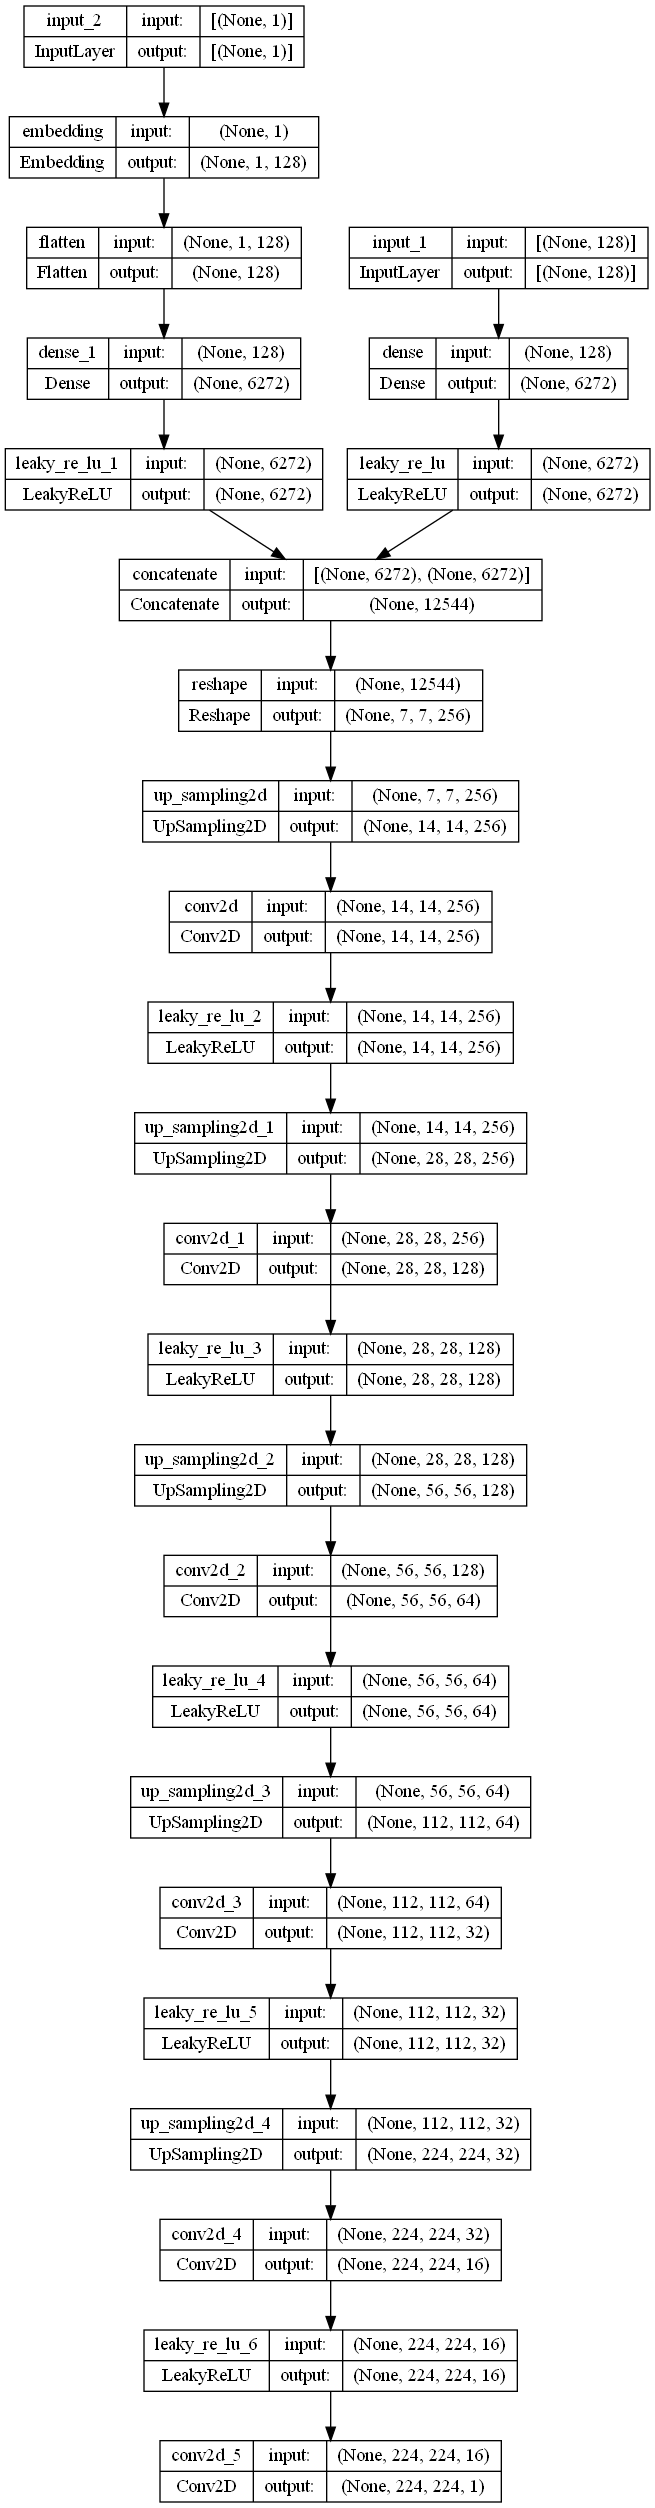

In [8]:
from keras.utils.vis_utils import plot_model

plot_model(cgan_generator, to_file='cgan_generator.png', show_shapes=True, show_layer_names=True)

#### 4.2 Generate new images

1/1 [==============================] - 0s 264ms/step


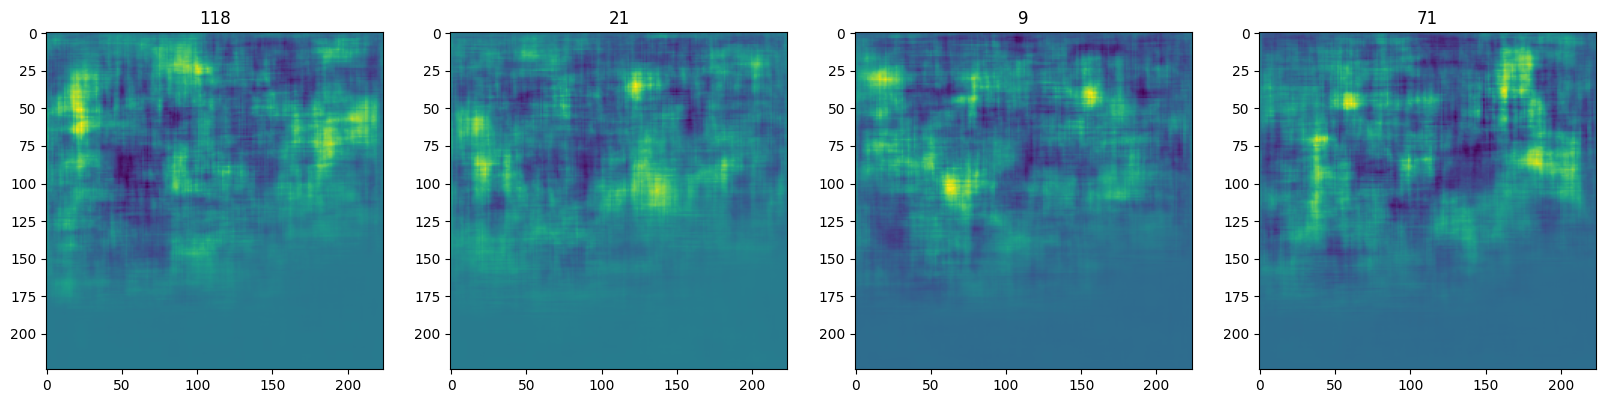

In [9]:
import numpy as np

# generate new images
noise = np.random.randn(4, 128)
# generate 4 random labels
labels = np.random.randint(0, 144, 4).reshape(-1, 1)
# provide noise and labels as a list of inputs
imgs = cgan_generator.predict([noise, labels])

# print the images that we generated
fix, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(imgs):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(labels[idx][0])

#### 4.3 Building Discriminator

In [10]:
from keras.layers import Input, Dense, Reshape, LeakyReLU, Conv2D, Flatten, Concatenate, RepeatVector
from keras.models import Model


def build_cgan_discriminator(image_shape=(224, 224, 1), num_classes=144):
    # Image input
    image = Input(shape=image_shape)
    x = Conv2D(64, 5, strides=2, padding='same')(image)
    x = LeakyReLU(0.2)(x)

    # Label input
    label = Input(shape=(1,))
    label_layer = Dense(112 * 112)(label)  # Downsample label input
    label_layer = Reshape((112, 112, 1))(label_layer)
    label_layer = Flatten()(label_layer)  # Flatten label_layer
    # Repeat label_layer along a new axis
    label_layer = RepeatVector(64)(label_layer)
    label_layer = Reshape((112, 112, 64))(
        label_layer)  # Reshape label_layer to match x

    # Concatenate image and label layers
    concat = Concatenate(axis=-1)([x, label_layer])

    # Conv2D and LeakyReLU layers
    x = Conv2D(128, 5, strides=2, padding='same')(concat)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256, 5, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(512, 5, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    # Flatten and Dense layers
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model([image, label], x, name='cgan_discriminator')

    return model


# Create conditional GAN discriminator
cgan_discriminator = build_cgan_discriminator()
cgan_discriminator.summary()

Model: "cgan_discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 12544)        25088       ['input_4[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 112, 112, 1)  0           ['dense_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                               

In [11]:
cgan_discriminator.predict([imgs, labels])

1/1 [==============================] - 0s 189ms/step


array([[0.5263452 ],
       [0.5038366 ],
       [0.50032765],
       [0.5151217 ]], dtype=float32)

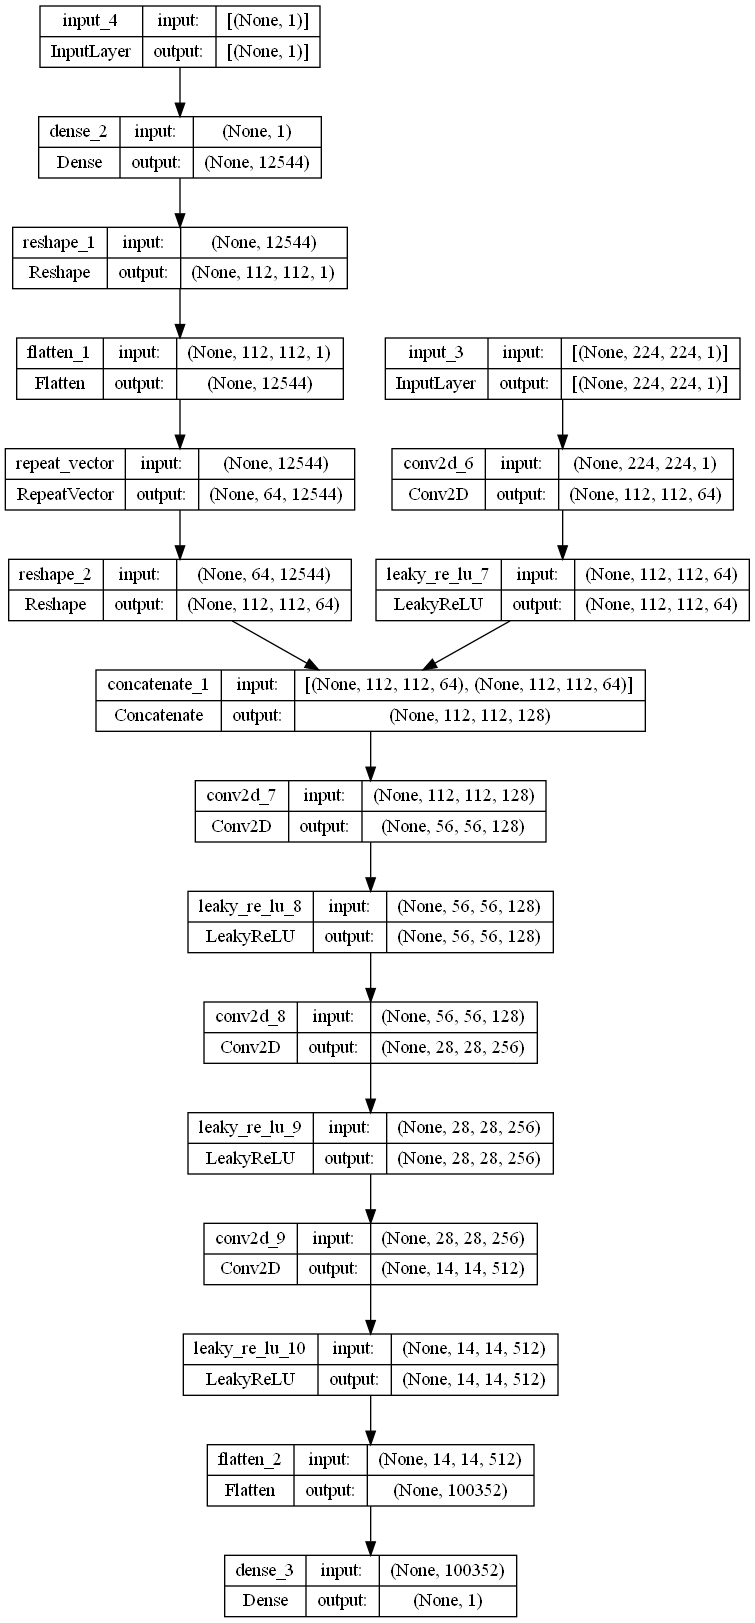

In [12]:
plot_model(cgan_discriminator, to_file='cgan_discriminator.png', show_shapes=True, show_layer_names=True)

### 5. Construct Training Loop

#### 5.1 Setup Loss Functions and Optimizers

In [13]:
# Adam is going to be the optimizer for both
from keras.optimizers import Adam
# Binary Crossentropy is going to be the loss func for both
from keras.losses import BinaryCrossentropy

In [14]:
# The learning rates for the generator and discriminator are often set differently
# to maintain a balance between the two during training. If the discriminator
# learns too quickly, it may overfit to the current generator's output and fail to
# provide useful feedback for the generator to improve. On the other hand, if the
# generator learns too quickly, it might produce images that don't resemble the
# training data.

g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

#### 5.2 Build Subclass Model

In [15]:
# import the base model class to suclass our training step
from keras.models import Model
import tensorflow as tf

In [16]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, loss_fn, g_optimizer, d_optimizer, *args, **kwargs):
        super(GAN, self).compile()

        self.loss_fn = loss_fn
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer

    def train_step(self, data):
        real_images, labels = data

        # Convert labels to integers
        labels = tf.cast(labels, tf.int32)

        # Convert labels to one-hot vectors
        labels = tf.one_hot(labels, depth=144)

        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, 128))

        # Decode them to fake images
        generated_images = self.generator([random_latent_vectors, labels])

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels_discriminator = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                [combined_images, labels_discriminator])
            d_loss = self.loss_fn(labels_discriminator, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, 128))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                [self.generator([random_latent_vectors, labels]), misleading_labels])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [17]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.00002, beta_1=0.5)
loss_function = BinaryCrossentropy(from_logits=True)

# Instantiate the GAN model
gan = GAN(generator=cgan_generator, discriminator=cgan_discriminator)

# Compile the GAN model
gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    loss_fn=loss_function
)

#### 5.3 Build Callback

In [18]:
from keras.utils import array_to_img
from keras.callbacks import Callback

In [19]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128, num_classes=144, save_dir='generated_images'):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            (self.num_img, self.latent_dim))
        random_labels = tf.random.uniform(
            (self.num_img, 1), minval=0, maxval=self.num_classes, dtype=tf.int32)
        generated_images = self.model.generator(
            [random_latent_vectors, random_labels])
        generated_images *= 255
        generated_images = generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            label = random_labels[i].numpy()[0]
            hour = label // 12
            minute = (label % 12) * 5
            time_dir = f'{hour:02d}-{minute:02d}'
            os.makedirs(os.path.join(self.save_dir, time_dir), exist_ok=True)
            img.save(os.path.join(self.save_dir, time_dir,
                     f'generated_img_{epoch}_{i}.png'))

#### 5.4 Train Model

In [20]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object
datagen = ImageDataGenerator(rescale=1./255)
train_dir = os.path.join(sdir_gray, 'train_gray')

# Load images from the specified directory
train_data = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),  # adjust this to the size of your images
    batch_size=32, # number of images to load at a time
    class_mode='categorical'  # use 'categorical' for multi-class problems
)

print(train_generator.next()[0].shape) # has a shape of (32, 224, 224, 1)

Found 11520 images belonging to 144 classes.
(32, 224, 224, 1)


In [21]:
import scipy

hist = gan.fit(
    train_data,
    epochs=20,
    callbacks=[ModelMonitor()],
    verbose=0
)
print("Batch size 1:", hist.history['batch_size'][0])

# save the model
gan.save('cgan_model_20_epocs.h5')

c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\backend.py:5677: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"


InvalidArgumentError: Graph execution error:

Detected at node 'cgan_generator/dense_1/BiasAdd_1' defined at (most recent call last):
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\asyncio\base_events.py", line 539, in run_forever
      self._run_once()
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\asyncio\base_events.py", line 1775, in _run_once
      handle._run()
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\IPython\core\interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\IPython\core\interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\dimau\AppData\Local\Temp\ipykernel_21176\3365843873.py", line 7, in <module>
      verbose=0
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\dimau\AppData\Local\Temp\ipykernel_21176\2684187347.py", line 55, in train_step
      [self.generator([random_latent_vectors, labels]), misleading_labels])
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dimau\Anaconda3\envs\clock\lib\site-packages\keras\layers\core\dense.py", line 252, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'cgan_generator/dense_1/BiasAdd_1'
Matrix size-incompatible: In[0]: [32,2654208], In[1]: [128,6272]
	 [[{{node cgan_generator/dense_1/BiasAdd_1}}]] [Op:__inference_train_function_3231]